## **背景描述**
为了调查吃巧克力对心血管健康的影响，实验由三种类型的巧克力组成：100g的黑巧克力，含有200mg全脂牛奶的100g黑巧克力和200g的牛奶巧克力。12个实验对象：7女5男。在不同的天数里，每个实验对象将吃一种类型的巧克力，一个小时后测量他们血浆的总抗氧能力。

## **数据描述**
实验次序本身具有随机性，无需再随机化。请使用Project_1.csv中的数据集。数据字典如下表所示。

| 变量名 | 变量含义 | 变量类型 | 变量取值范围 |
|:-----:|:-----:|:-----:|:-----:|
| Chocolate | 巧克力类型 | 分类变量 | $\{1,2,3\}$ |
| Capacity | 血浆浓度 | 连续变量 | $R$ |

## **问题**
注： 显著性水平 $\alpha$ 取 0.05。

1. 两两比较 3 种巧克力对心血管健康的影响是否存在差异。
2. 判断 3 种巧克力对心血管健康的影响是否有差异。
3. 试说明所使用模型的合理性。
4. 估计食用这 3 种巧克力一小时后血浆的总抗氧能力。请分别给出点估计和区间估计。
5. 用Bonferroni方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。
6. 用Tukey方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。采用以下两种不同的方法来解决这个问题：
    - 直接调用python中现有函数；
    - 用蒙特卡洛随机模拟分布的方式，确定 $t$ 化极差统计量的分位数 $q_{1-\alpha}(a,df)$，计算临界值(critical value) $c=q_{1-\alpha}(a,df)\hat{\sigma}/\sqrt{m}$。
7. 基于这个例子，请评述一下Bonferroni方法和Tukey方法的异同。

## **解决方案**

### **实验前的准备** 

本次实验我们载入一些Python的安装包，如下：

In [134]:
import os # 修改工作目录

import numpy as np
import pandas as pd
import scipy.stats as stats # 统计函数
import matplotlib.pyplot as plt
from plotnine import * # ggplot 绘图
import seaborn as sns
from plotnine.data import mpg
from jupyterquiz import display_quiz # Quiz

#from ggplot import ggplot

import math

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f
from scipy.stats import t
from statsmodels.stats.stattools import durbin_watson

# multiple comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

设置数据目录，如下：

In [5]:
os.chdir(r"C:\Users\86182\Desktop\Statistic\project1") 

### **数据预处理**

In [22]:
alpha = 0.05 # significant level
a = 3 # number of levels
m = 12 # number of replicates
n = a*m # sample size

导入并查看数据集，该数据集展示了 12 名实验对象吃完三种不同种类巧克力后的不同血浆浓度。

In [6]:
print('Data is shown as follows: \n', pd.read_csv("Project_1.csv"))

Data is shown as follows: 
     Obs  Chocolate  Capacity
0     1          1     118.8
1     2          1     122.6
2     3          1     115.6
3     4          1     113.6
4     5          1     119.5
5     6          1     115.9
6     7          1     115.8
7     8          1     115.1
8     9          1     116.9
9    10          1     115.4
10   11          1     115.6
11   12          1     107.9
12    1          2     105.4
13    2          2     101.1
14    3          2     102.7
15    4          2      97.1
16    5          2     101.9
17    6          2      98.9
18    7          2     100.0
19    8          2      99.8
20    9          2     102.6
21   10          2     100.9
22   11          2     104.5
23   12          2      93.5
24    1          3     102.1
25    2          3     105.8
26    3          3      99.6
27    4          3     102.7
28    5          3      98.8
29    6          3     100.9
30    7          3     102.8
31    8          3      98.7
32    9        

我们关心的是巧克力类型引起的血浆浓度变化，为了简化后续操作，我按照巧克力类型把数据集分为三部分，如下。

In [53]:
data = pd.read_csv(r"C:\Users\86182\Desktop\Statistic\project1\Project_1.csv")

chocolate_1 = data[data['Chocolate'] == 1]['Capacity']
chocolate_2 = data[data['Chocolate'] == 2]['Capacity']
chocolate_3 = data[data['Chocolate'] == 3]['Capacity']

print(chocolate_1, chocolate_2, chocolate_3, sep="\n")

0     118.8
1     122.6
2     115.6
3     113.6
4     119.5
5     115.9
6     115.8
7     115.1
8     116.9
9     115.4
10    115.6
11    107.9
Name: Capacity, dtype: float64
12    105.4
13    101.1
14    102.7
15     97.1
16    101.9
17     98.9
18    100.0
19     99.8
20    102.6
21    100.9
22    104.5
23     93.5
Name: Capacity, dtype: float64
24    102.1
25    105.8
26     99.6
27    102.7
28     98.8
29    100.9
30    102.8
31     98.7
32     94.7
33     97.8
34     99.7
35     98.6
Name: Capacity, dtype: float64


### **Q1.两两比较 3 种巧克力对心血管健康的影响是否存在差异。**

我们首先绘制一张图来刻画三种巧克力类型对血浆浓度影响的分布，如下图。

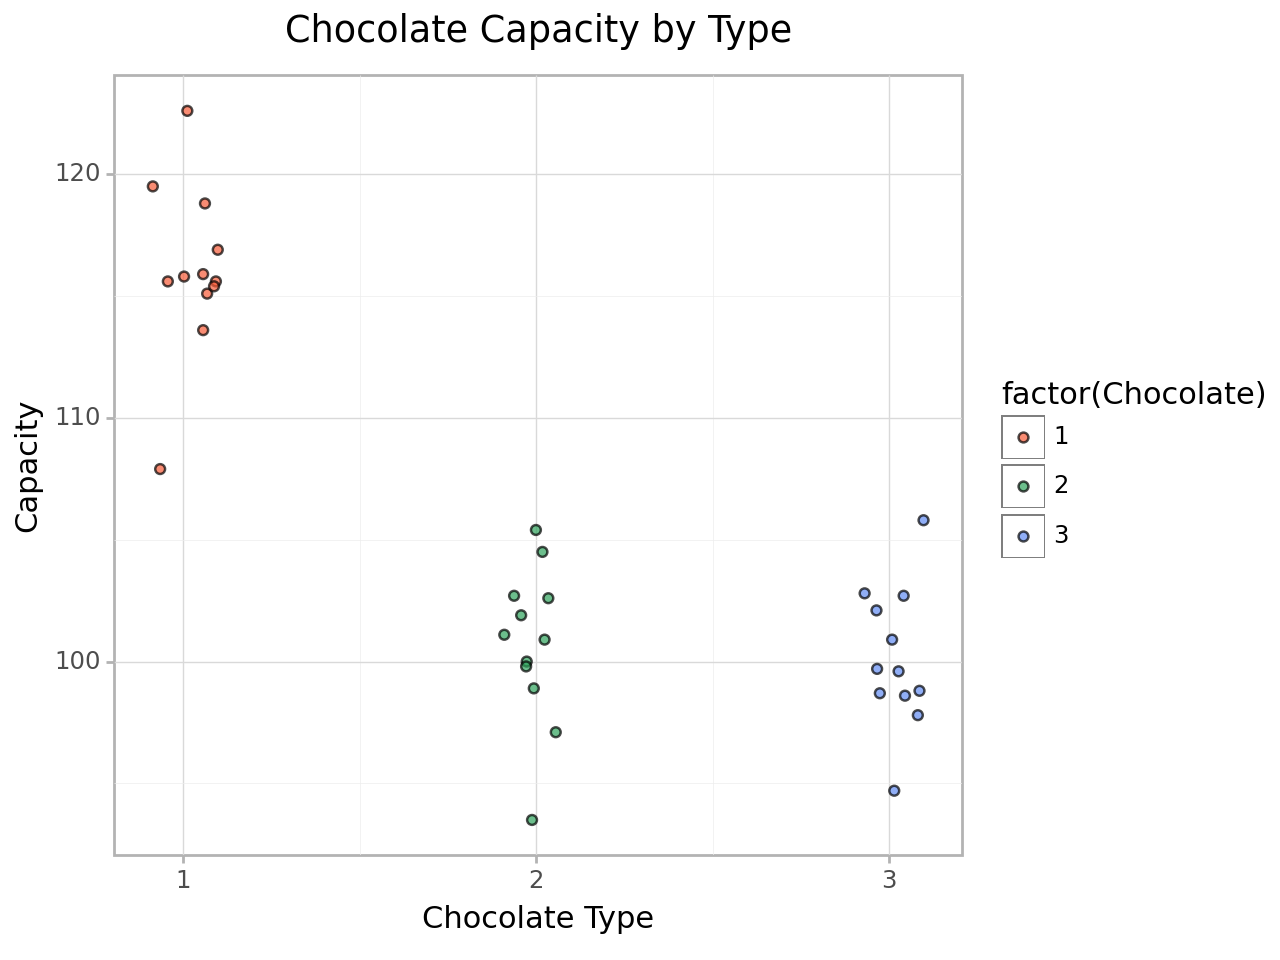

In [21]:
plot = (
    ggplot(data, aes(x='Chocolate', y='Capacity', fill='factor(Chocolate)'))
    + geom_jitter(width=0.1, height=0, alpha=0.7)  # 添加抖动
    + scale_fill_hue(s=0.90, l=0.60, h=0.05, color_space='husl')
    + labs(x='Chocolate Type', y='Capacity', title='Chocolate Capacity by Type')
    + scale_x_continuous(breaks=[1, 2, 3])  # 设置x轴只显示1, 2, 3
    + theme_light()  # 设置主题
    + theme(plot_title=element_text(ha='center'))  # 设置标题居中
)

print(plot)

在上图中，可以从直观上比较三种巧克力类型对血浆浓度的影响。对于巧克力$1$，实验对象的血浆浓度集中在 115 附近，对于巧克力$2$和$3$，实验对象的血浆浓度集中在 100 附近。感觉上，3种巧克力对心血管健康的影响是存在差异的。但是，这种“区别”会否是由于实验对象个体差异所造成的？还是这种“区别”是明显地有别于个体差异的？我们仍需要用量化的手段加以衡量。为了比较两组数据是否存在差异，一种常用的方法是二样本独立$t$检验。

- #### 二样本独立 $t$ 检验

    假定第一组数据 $x_1,x_2,\cdots,x_m$ 来自一个正态分布 $N(\mu_1,\sigma^2)$，第二组数据 $y_1,y_2,\cdots,y_n$ 来自另一个正态分布 $N(\mu_2,\sigma^2)$，并且这两个正态分布是相互独立的。于是，比较两组数据差异的问题，就转化为比较两个总体均值差异的问题。通常，我们会考虑这样的一对假设，即原假设和备择假设分别为
    $$
    H_0: \mu_1 = \mu_2, \quad \text{vs} \quad H_1: \mu_1\neq \mu_2.
    $$
    为解决这个问题，我们构建了一个检验统计量为
    $$
    t_0 = \frac{ (\bar{x} - \bar{y})}{\sqrt{s_w^2 (m^{-1} + n^{-1})}}.
    $$
    其中，
    - $\bar{x} = m^{-1} \sum_{i=1}^m x_i$ 表示第一组的样本均值；
    - $\bar{y} = n^{-1} \sum_{i=1}^n y_i$ 表示第二组的样本均值；
    - $s_w^2 = \frac{(m-1)\sum{i=1}^{m}(x_i-\bar{x})^2 + (n-1)\sum_{i=1}^n (y_i-\bar{y})^2}{m+n-2}$ 表示两组样本的合方差。

    可以证明，在原假设成立的情况下，$t \sim t(m+n-2)$。于是，我们可以构造拒绝域为 $\{|t_0| > t_{1-\alpha/2}(m+n-2)\}$。当样本落入拒绝域时，则拒绝原假设；反之，则无法拒绝原假设。除了构造拒绝域这一方法之外，我们还可以计算其 $p$ 值，即
    $$
    p = 2\times P(t_{m+n-2} > |t_0|) .
    $$
    如果 $p$ 值小于显著性水平 $\alpha$，则拒绝原假设；反之，则无法拒绝原假设。

    注：在这个问题中，$m=n=12$。

#### **巧克力$1$ VS 巧克力$2$**

首先，我们可以计算$t$检验统计量并与其相应的临界值（即 $t_{1-\alpha/2}(m+n-2)$）进行比较：

In [54]:
t0, pVal0 = stats.ttest_ind(chocolate_1, chocolate_2)

print("t statistic is:" ,round(t0,4))
print("critical value is：", round(t.ppf(1-alpha/2,12*2-2),4))

t statistic is: 11.1057
critical value is： 2.0739


我们发现，$t$ 检验统计量的绝对值比临界值大得多，所以，拒绝原假设，接受备择假设，也就是说，巧克力$1$和$2$对心血管健康的影响有显著差异。

除了上述方法之外，我们也可以采用 $p$ 值来得到结论。具体来说，我们可以计算 $p$ 值为：

In [37]:
print("p-value is:", pVal0)

p-value is: 1.7330939682091152e-10


由于 $p$ 值比显著性水平 $\alpha$ 小得多，所以,拒绝原假设，接受备择假设。

#### **巧克力$1$ VS 巧克力$3$**

In [55]:
t1, pVal1 = stats.ttest_ind(chocolate_1, chocolate_3)

print("t statistic is:" ,round(t1,4))
print("critical value is：", round(t.ppf(1-alpha/2,12*2-2),4))
print("p-value is:", pVal1)

t statistic is: 12.0478
critical value is： 2.0739
p-value is: 3.6833891525708707e-11


$t$ 检验统计量的绝对值比临界值大得多，$p$ 值比显著性水平 $\alpha$ 小得多，所以，拒绝原假设，接受备择假设，也就是说，巧克力$1$和$3$对心血管健康的影响有显著差异。

#### **巧克力$2$ VS 巧克力$3$**

In [56]:
t2, pVal2 = stats.ttest_ind(chocolate_2, chocolate_3)

print("t statistic is:" ,round(t2,4))
print("critical value is：", round(t.ppf(1-alpha/2,12*2-2),4))
print("p-value is:", pVal2)

t statistic is: 0.4126
critical value is： 2.0739
p-value is: 0.6838877988482657


$t$ 检验统计量的绝对值比临界值小得多，$p$ 值比显著性水平 $\alpha$ 大，所以，无法拒绝原假设，也就是说，巧克力$2$和$3$对心血管健康的影响无显著差异。

**综上所述，我们认为：**
- 巧克力$1$和$2$对心血管健康的影响有显著差异
- 巧克力$1$和$3$对心血管健康的影响有显著差异
- 巧克力$2$和$3$对心血管健康的影响无显著差异

### **Q2.判断 3 种巧克力对心血管健康的影响是否有差异。**

该问题本质上可转化为，实验对象食用不同类型巧克力后测量的血浆浓度分布是否存在差异。对于 $a=2$ 组样本的均值比较，最为常用的方法是 $t$ 检验。然而，对于$a\geq 2$时，更为一般的方法是**单因素方差分析模型**。

- #### 单因素方差分析（One-way ANOVA）模型

    假设有 $a$ 组数据，每组数据有 $m$ 个，于是，共有 $n = am$ 个数据。对于第$i$组的数据而言，我们将数据记为$y_{i1},y_{i2},\cdots,y_{ij},\cdots,y_{im}$。
    在方差分析模型中，我们假定:

    - 每一个数据 $y_{ij} = \mu + \alpha_i + \epsilon_{ij}$，其中，$\mu$ 是未知参数，表示总体均值，与组别和数据差异无关；$\alpha_i$ 是未知参数，表示组内均值，与数据差异无关，$\sum_{i=1}^a\alpha_i = 0$；$\epsilon_{ij}$ 是随机误差，表示数据之间的差异；

    - $\epsilon_{ij}\overset{i.i.d}{\sim}N(0,\sigma^2)$，$\sigma^2$ 表示数据的波动。

    根据上述假定，易知
    $$
    y_{ij} \sim N(\mu+\alpha_i , \sigma^2) \quad \text{$x_{ij}$ 之间相互独立。}
    $$
    基于上述假定，“数据分布一致的问题”可以转化为“均值是否相等的问题”。我们构建了一对假设，分别为
    $$
    H_0: \alpha_1 = \alpha_2 = \alpha_3 = 0 \quad \text{vs} \quad H_1: \text{$\alpha_i$ 不全相等。}
    $$

    在方差分析模型中，我们需要建立方差分析表，即

    | 来源  | 自由度 | 平方和  | 均方 | 统计量 | 
    | :----:  | :----: |  :----: | :----: | :----: |
    | 因子  | $a-1$ | $SS_A$ | $MS_A= \frac{SS_A}{a-1}$ | $F_A=\frac{MS_A}{MS_E}$ |
    | 误差 | $n-a$ | $SS_E$ | $MS_E= \frac{SS_E}{n-a}$ |  |
    | 总和 | $n-1$ | $SS_T$ |    |  |

    其中，
    - $SS_A = m\sum_{i=1}^{a} (\bar{y}_{i\cdot}-\bar{y}_{\cdot\cdot})^2$;
    - $SS_E = \sum_{i=1}^{a} \sum_{j=1}^m (y_{ij} - \bar{y}_{i\cdot})^2$;


#### **临界值法**

In [44]:
# 拟合模型
model = ols('Capacity ~ C(Chocolate)', data=data).fit()  # C() 用于将分类变量转为因子
# 进行方差分析
anova_results = anova_lm(model)

# 输出 ANOVA 表
print("\nThe ANOVA table: \n", round(anova_results, 4))


The ANOVA table: 
                 df     sum_sq   mean_sq        F  PR(>F)
C(Chocolate)   2.0  1952.6439  976.3219  93.5756     0.0
Residual      33.0   344.3058   10.4335      NaN     NaN


In [48]:
# 计算临界值
f_value = f.ppf(1 - alpha, a-1, n-a)
print(f"F临界值 = {f_value:.4f}")

F临界值 = 3.2849


由输出结果可知，$F$ 检验统计量为 93.5756，远大于临界值 3.2849，所以我们拒绝原假设，接受备择假设，即认为至少存在两种巧克力对心血管健康的影响有差异。

#### **$p$ 值判断法**

In [57]:
# 进行单因素方差分析
F_stat, F_pVal = stats.f_oneway(chocolate_1, chocolate_2, chocolate_3)

# 输出结果
print("The test statistic in One-way ANOVA model is", round(F_stat, 4))
print("The p value in One-way ANOVA model is", F_pVal, 4)

The test statistic in One-way ANOVA model is 93.5756
The p value in One-way ANOVA model is 2.5152590041682955e-14 4


由输出结果可知，$p$ 值远小于显著性水平 $\alpha$，所以拒绝原假设。

**综上所述，我们认为：**
- 3 种巧克力对心血管健康的影响有差异。

### **Q3.试说明所使用模型的合理性。**

模型一般是有适用范围的。在实际应用中，我们需要考虑模型是否符合数据的特征。

在单因素方差分析的模型中，我们所提出的所有假设都是关于**误差**的。具体来说，单因素方差分析模型为

$$y_{ij} = \mu + \alpha_i + \epsilon_{ij}$$

其中，$\epsilon \overset{i.i.d}{\sim} N(0,\sigma^2)$.

关于误差，我们总共提了三个假设：
- 独立性
- 同方差
- 正态性

这三个假设的重要性也是从高到低进行排列的。

验证模型是否合理，本质上就是在检验上述三个假设是否成立。
但是，**误差是无法观测到的**。于是，我们给出一个新的概念——**残差**。
- 从本质上来说，误差是数据与其真实均值的差距，即
$$\epsilon_{ij} = y_{ij} - \mu - \alpha_i$$
- 残差本质上是数据与所拟合模型之间的差异，即
$$
e_{ij} = y_{ij} - \hat{y}_{ij}
$$ 
其中，$\hat{y}_{ij} = \hat{\mu} + \hat{\alpha}_i = \bar{y}_{\cdot\cdot} + (\bar{y}_{i\cdot} - \bar{y}_{\cdot\cdot}) = \bar{y}_{i\cdot}$ 表示 $y_{ij}$ 所对应的拟合值或预测值，这些概念同样也可以在线性回归模型中使用。

首先计算残差并画出残差图，对其分布有一个直观的把握：

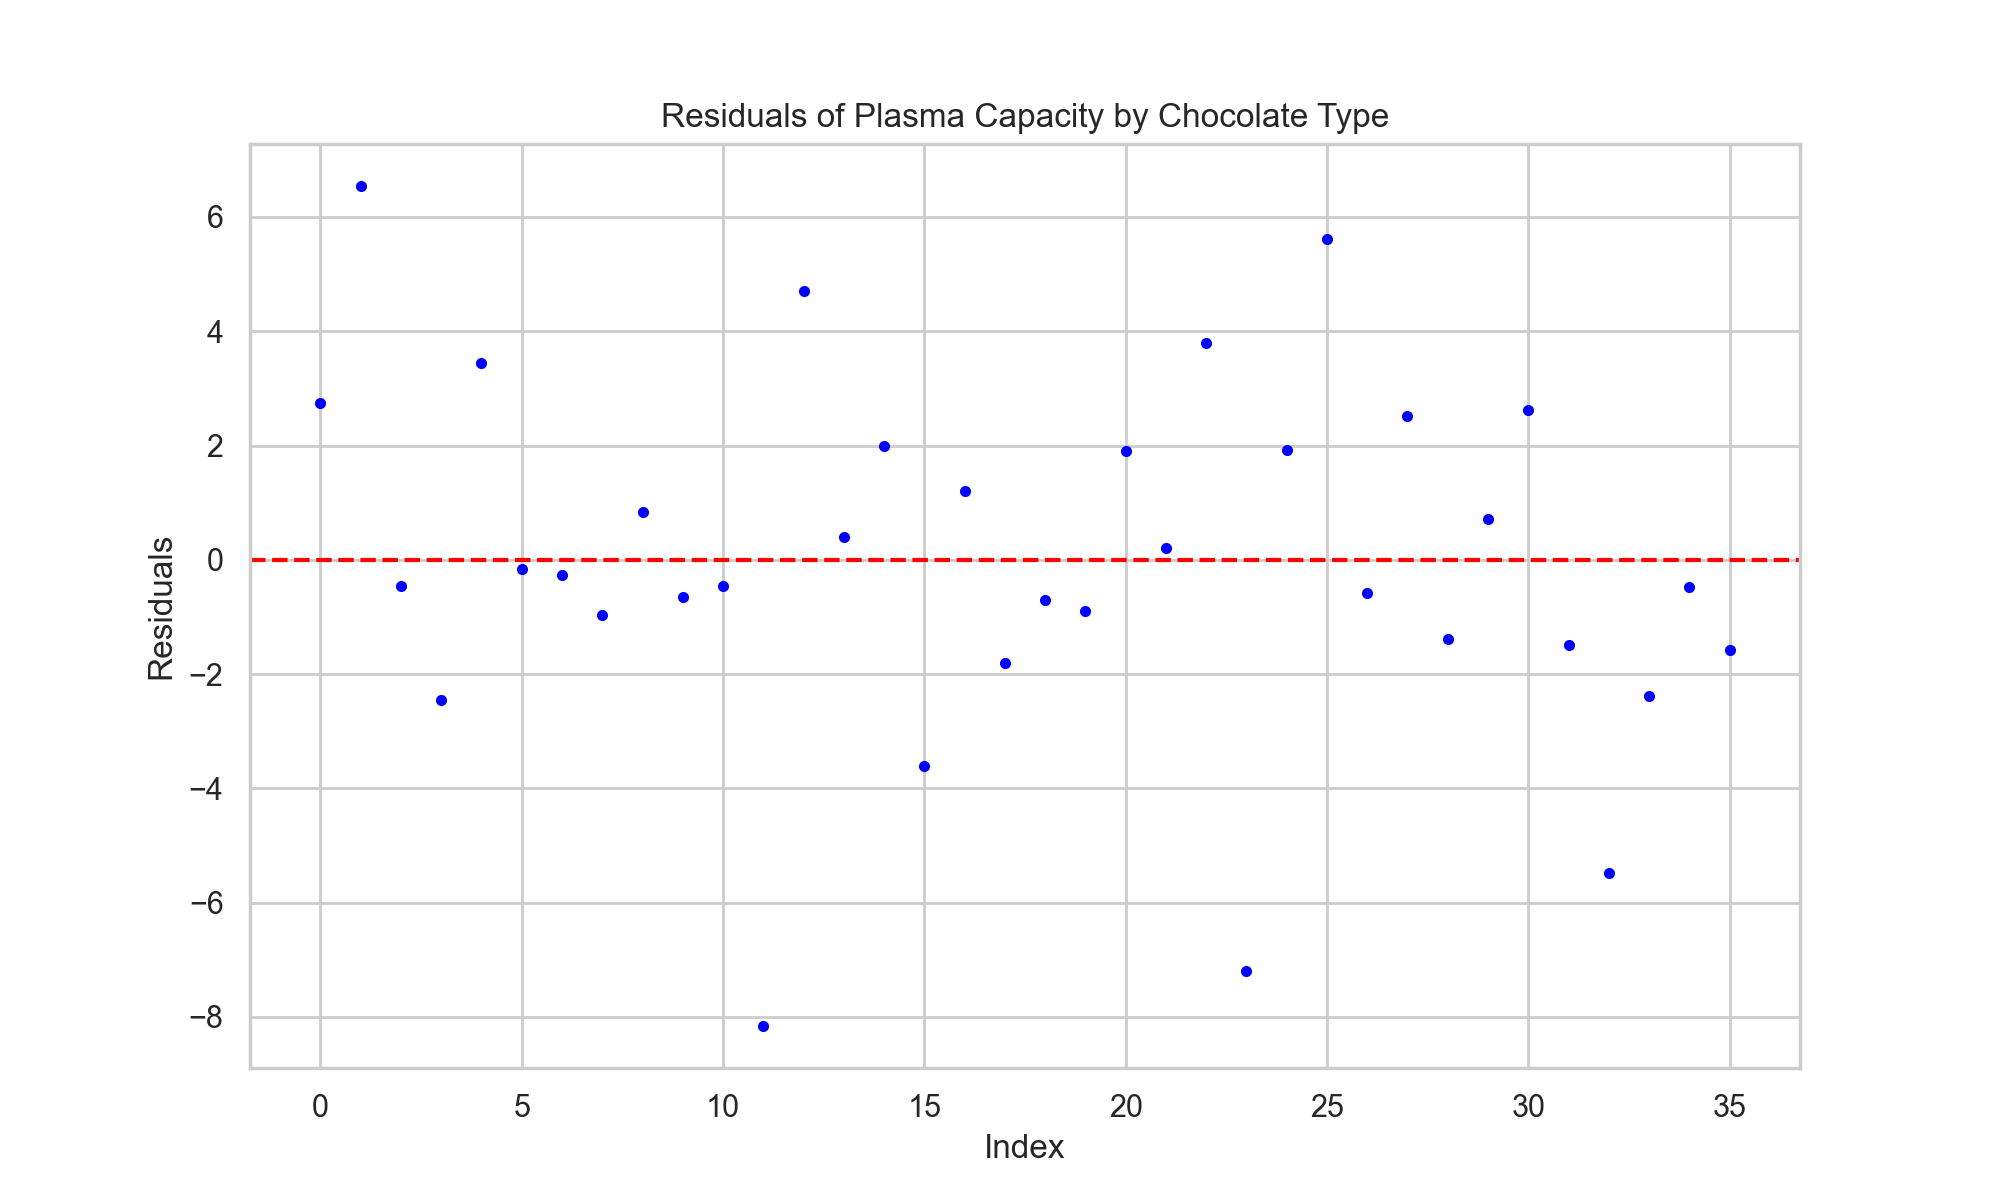

In [169]:
# 计算残差
residuals_1 = chocolate_1 - chocolate_1.mean()
residuals_2 = chocolate_2 - chocolate_2.mean()
residuals_3 = chocolate_3 - chocolate_3.mean()

# 合并残差
residuals = np.concatenate((residuals_1, residuals_2, residuals_3))

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker=".", color="blue", linestyle="none")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residuals of Plasma Capacity by Chocolate Type")
plt.axhline(0, color='red', linestyle='--')  # 添加y=0的参考线
plt.show()

#### **独立性检验**

一种常见具有不独立特点的数据具有自相关性。
- ##### Durbin-Watson检验（简称“DW检验”）
    这是一种检验序列是否存在一阶自相关性的常用方法。
    对于残差序列 $\{e_i, i = 1,2,\cdots,n,\cdots\}$，考虑残差相关性方程为
    $$
    e_{i} = \rho e_{i-1} + v_{i}, \quad v_i \overset{i.i.d}{\sim} N(0,\sigma_v^2)，
    $$
    其中，$|\rho| < 1$。

    在Durbin-Watson检验中，我们需要检验这样一对假设
    $$
    H_0 : \rho = 0 \quad \text{vs} \quad H_1: \rho > 0.
    $$
    可以注意到，$\rho = 0$ 表示残差序列无自相关性。也就是说，如果我们接受原假设，那么我们就认为序列数据是满足独立性的。

    DW检验统计量为
    $$
    DW = \frac{\sum_{i=2}^n (e_i - e_{i-1})^2}{\sum_{i=1}^n e_{i}^2}
    $$
    可以注意到，$DW \approx 2(1-r_1)$，其中$r_1$表示一阶滞后样本自相关系数，即
    $$
    r_1 = \frac{\sum_{i=2}^{n} e_{i-1}e_{i}}{\sum_{i=1}^n e_{i}^2}.
    $$
    对于无相关性的残差序列，$r_1$接近于零，所以$DW$统计量接近于$2$。

    判断规则为
    - 如果 $DW < d_L$, 那么拒绝原假设；
    - 如果 $DW > d_U$, 那么接受原假设；
    - 如果 $d_L \leq DW \leq d_U$, 那么无法判断。

    $d_L$和$d_U$与样本量、线性模型中特征个数以及显著性水平有关。具体可以查表，如下：
    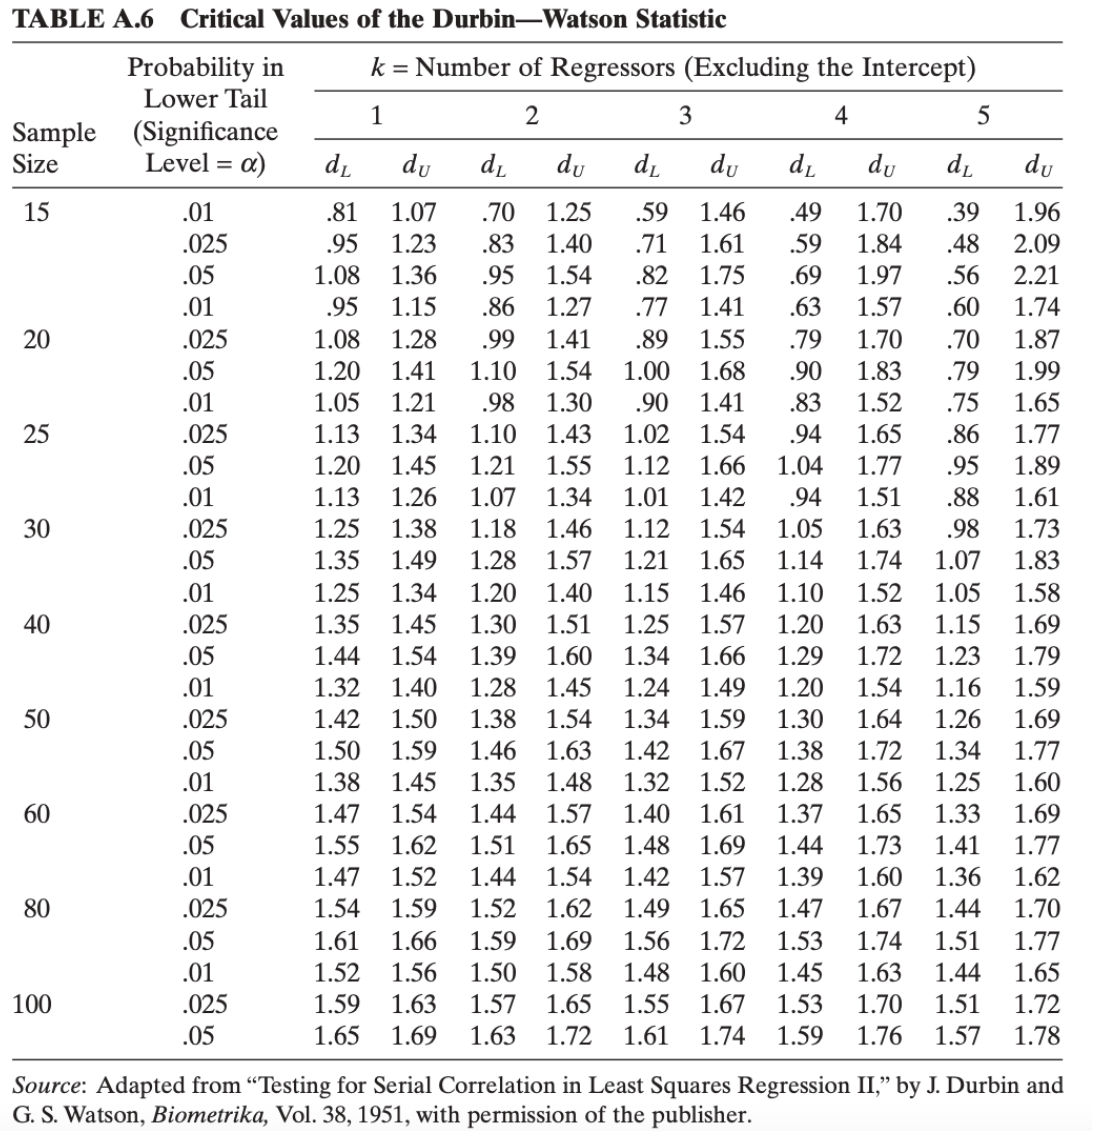

用 Python 计算出 $DW$ 检验统计量：

In [166]:
DW = durbin_watson(residuals)
print("DW statistic is", round(DW,4))

DW statistic is 2.2991


查表知 $D_L = 1.35,D_U=1.49,DW \ge D_U$，

**综上所述，**<br>
接受原假设，即认为序列数据满足独立性。

#### **方差齐性检验**

方差齐性检验的目的是判断各组数据的方差是否相等。对于第 $i$ 组的数据而言，
$$
x_{ij} \sim N(\mu+\alpha_i, \sigma_i^2) , i=1,2,\cdots,a; j=1,2,\cdots,m_i.
$$
在方差齐性检验中，我们提出这样的一对假设
$$
H_0: \sigma_1^2 = \sigma_2^2 =\cdots = \sigma_a^2 \quad \text{vs}\quad H_1: \text{至少存在两组数据，$\sigma_i^2 \neq \sigma_j^2$}.
$$

首先画出每种巧克力的残差分布图，以便对其有一个直观的把握：

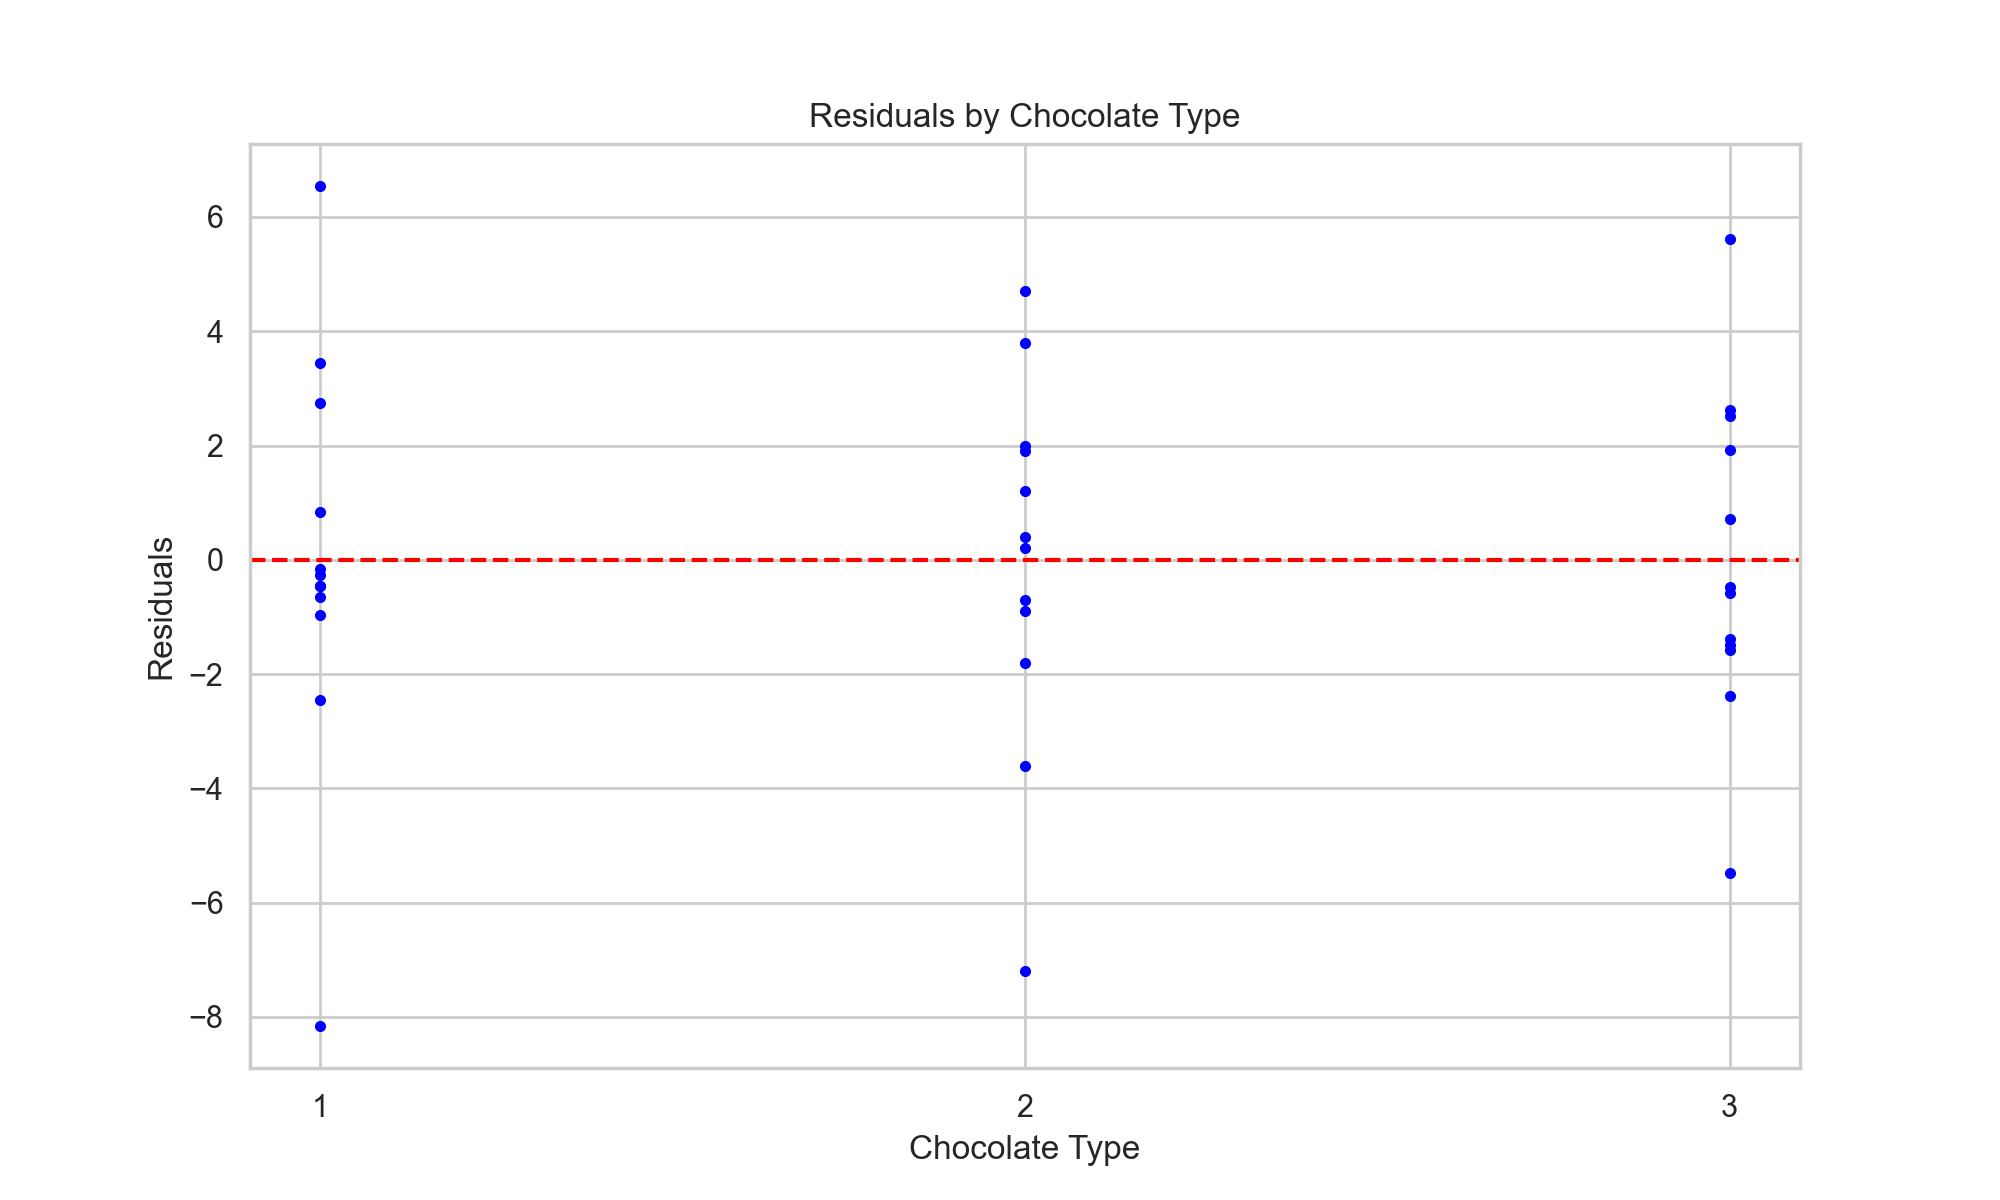

In [171]:
# 创建巧克力类型标签
chocolate_types = np.concatenate((
    np.ones(len(residuals_1)), 
    np.ones(len(residuals_2)) * 2, 
    np.ones(len(residuals_3)) * 3
))

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.plot(chocolate_types, residuals, ".", color="blue")  # 使用蓝色点绘制
plt.xlabel("Chocolate Type")
plt.ylabel("Residuals")
plt.title("Residuals by Chocolate Type")
plt.axhline(0, color='red', linestyle='--')  # 添加y=0的参考线
plt.xticks([1, 2, 3])  # 设置x轴只显示巧克力类型1, 2, 3
plt.show()

- ##### **Bartlett检验**
    在Bartlett检验中，所使用的检验统计量为
    $$
    \chi_0^2 = 2.3026 \frac{q}{c}
    $$
    其中，
    - $ q = (n - a) \log_{10}s_p^2 - \sum_{i=1}^a (m_i-1)  \log_{10}s_i^2 $；
    - $c = 1 + \frac{1}{3(a-1)}\left( \sum_{i=1}^a (m_i-1)^{-1} - (n-a)^{-1} \right)$；
    - $s_p^2 = \frac{\sum_{i}  (m_i-1)s^2_i}{n-a}$；
    - $s_i^2$ 表示第$i$组数据的样本方差。

    注意到，如果样本方差 $s_i^2$ 差异大，那么 $q$ 非常大；如果样本方差 $s_i^2$ 完全一致，那么 $q$ 为零。基于这个想法，如果检验统计量 $\chi_0^2$ 过大，那么我们就拒绝原假设。具体来说，我们拒绝原假设当且仅当
    $$
    \chi_0^2 > \chi_{1-\alpha,a-1}^2
    $$
    其中 $\chi_{1-\alpha,a-1}^2$ 是自由度为 $a-1$ 的卡方分布的 $1-\alpha$ 分位数。

    然而，Bartlett检验存在一个**缺陷**：Bartlett检验对正态分布假定非常敏感。如果数据背离正态性假定，建议不要使用Bartlett检验。

使用 Python 实现 Bartlett 检验：

In [173]:
# Bartlett's Test
Bart_stat, Bart_pVal = stats.bartlett(chocolate_1, chocolate_2, chocolate_3)
chi_square_value = stats.chi2.ppf(1 - alpha, a-1)

print("Bartlett's test statistic is", round(Bart_stat,4))
print(f"The {1-alpha} percentile of the chi-squared distribution with {a-1} degrees of freedom is: {chi_square_value:.4f}")
print("The p value is", round(Bart_pVal,4))

Bartlett's test statistic is 0.4247
The 0.95 percentile of the chi-squared distribution with 2 degrees of freedom is: 5.9915
The p value is 0.8087


通过计算结果可知 $p$ 值 $=0.8087$ 大于显著性水平 $0.05$ 且检验统计量 $\chi_0^2 = 0.4247 $ 小于临界值 $5.9915$

**综上所述，**<br>
接受原假设，即各组数据具有方差齐性。

- ##### **修正后 Levene 检验**

    因为 Bartlett 对正态性假定的敏感性，所以对于背离正态性的数据，可以通过修正后的 Levene 检验来解决这个问题。令
    $$
    y_{ij}^{\ast} = |y_{ij} - \tilde{y}_{i}|, i = 1,2,\cdots,a; j = 1,2,\cdots,n_i.
    $$
    其中，$\tilde{y}_{i}$表示第$i$组数据的中位数。基于$\{y_{ij}^{\ast}\}$来构建服从 $F$ 分布的统计量。这个统计量可以用来评价每组数据的绝对偏差的均值是否相等，从而可以判断每组数据的波动是否一致。
    检验统计量可表示为：
    $$W = \frac{(n - a) \cdot \sum\limits_{i=1}^{a} m_i (\tilde{y}_{i \cdot} - \tilde{y}_{\cdot})^2}{\sum\limits_{i=1}^{a} \sum\limits_{j=1}^{m_i} (y_{ij}^* - \tilde{y}_{\cdot})^2}
$$
    临界值 $c$ 可通过 $F_{1-\alpha,a-1,n-a}$ 计算。

使用 Python 实现修正后 Levene 检验：

In [177]:
Lev_stat, Lev_pVal = stats.levene(chocolate_1, chocolate_2, chocolate_2)
critical_value = stats.f.ppf(1 - alpha, a - 1, n - a)
print("The critical value is", round(critical_value,4))
print("Levene's test statistic is", round(Lev_stat,4))
print("The p value is", round(Lev_pVal,4))

The critical value is 3.2849
Levene's test statistic is 0.0145
The p value is 0.9856


通过计算结果可知 $p$ 值 $=0.9856$ 大于显著性水平 $0.05$ 且检验统计量 $W = 0.0145 $ 小于临界值 $3.2849$

**综上所述，**<br>
接受原假设，即各组数据具有方差齐性。

#### **正态性检验**

- ##### **Quantile-Quantile图**
    我们可以先通过图象来判断数据是否满足正态性。
    Quantile-Quantile图（简称“QQ图”）是验证数据是否满足某一假定分布常用的一种方法。
    
    其思想是：<br>
    横坐标表示理论分布所对应的分位数，纵坐标表示经验分布所对应的分位数（样本分位数）。如果这些点是分布在一条直线上，那么可以判断数据服从该假定分布。

使用 Python 绘制 QQ 图：

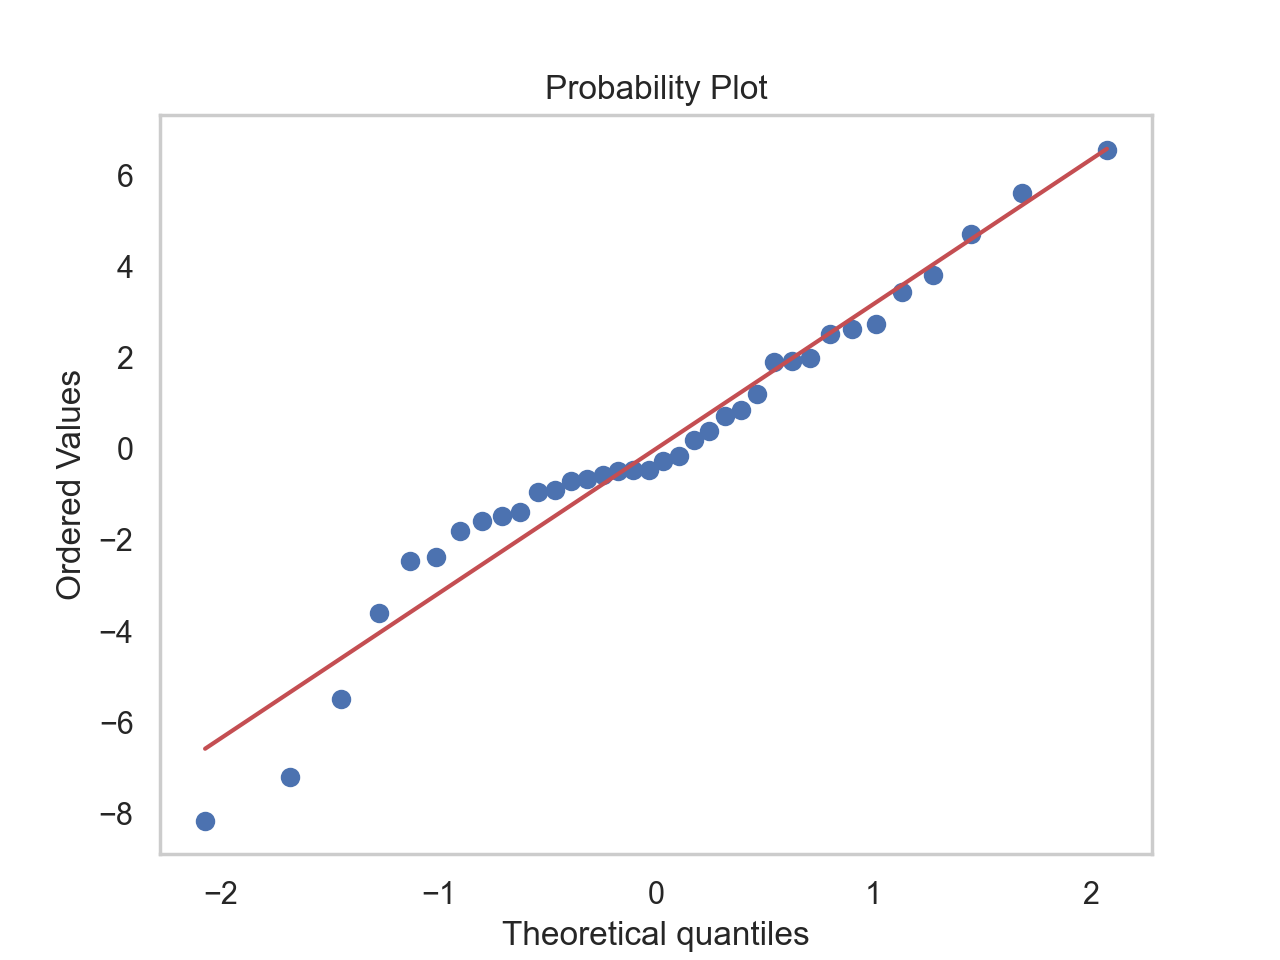

In [178]:
osm, osr = stats.probplot(residuals,dist= "norm",plot= plt)
plt.grid()
plt.show()

根据上图所示，总体上来看，残差分布可以认为是正态分布的。但左边的点上翘，它可能暗示数据分布的尾部较重，或者存在偏态（如左偏），即较多数据集中在右侧，导致左边的点高于理想的直线。

- ##### **异常值检测**

    基于残差，我们可以构造标准化残差，即
    $$
    d_{ij} = \frac{e_{ij}}{\sqrt{MS_E}}
    $$
    一般而言，如果残差满足正态分布，那么
    - 约 68\% 落在 $\pm 1$之内；
    - 约 95\% 落在 $\pm 2$之内；
    - 几乎全部落在 $\pm 3$之内。

    如果标准化残差的绝对值大于3，那么所对应的数据可以判断为异常值。

通过 Python 返回残差绝对值的最大值，并对其进行标准化：

In [183]:
max_abs_residual = np.max(np.abs(residuals))
d = max_abs_residual / np.sqrt(10.4335)

print("d_ij is",round(d,4))

d_ij is 2.5257


由计算结果可知，标准化残差的绝对值的最大值为 $2.5257$，小于 $3$ ，所以认为数据中不包含异常值。

- ##### **Shapiro-Wilk 检验**

    假设数据 $\{x_1,x_2,\cdots,x_n\}$ 来自正态总体 $N(\mu,\sigma^2)$。令 $x_{(1)}\leq x_{(2)}\leq \cdots \leq x_{(n)}$ 为其次序统计量。在Shapiro-Wilk 检验中，检验统计量为
    $$
    W = \frac{\left(\sum\limits_{i=1}^n (a_{i}-\bar{a}) (x_{i}-\bar{x})\right)^2}{\sum\limits_{i=1}^n (a_i-\bar{a})^2 \sum\limits_{i=1}^n (x_{(i)} - \bar{x})^2}
    $$
    其中 $a_1,a_2,\cdots,a_n$ 在给定样本量 $n$ 时是一些特定的值。这里可以近似的看作“理论分位数”。于是，检验统计量 $W$ 可以认为是理论分位数和样本分位数的相关系数的平方。如果它们约接近于一条直线，那么我们就认为数据是服从正态分布的。于是，我们所构造的拒绝域是 $\{W\leq W_{\alpha}\}$。<br>

    *PS.$ W_{\alpha}$ 需要通过查表得出。<br>*
    *PS. Shapiro-Wilk 检验更适用于小样本。*

使用 Python 实现 Shapiro-Wilk 检验：

In [179]:
SW_stat,SW_pVal = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic is", round(SW_stat,4))
print("The p value is", round(SW_pVal,4))

Shapiro-Wilk test statistic is 0.9625
The p value is 0.2572


通过计算结果可知 $p$ 值 $=0.2572$ 大于显著性水平 $0.05$

**综上所述，**<br>
接受原假设，即认为残差来自服从正态分布的总体。

#### **综上三方面检验，认为残差服从独立性、同方差和正态性，即该模型假设合理。**


### **Q4.估计食用这 3 种巧克力一小时后血浆的总抗氧能力。请分别给出点估计和区间估计。**

在单因素方差分析模型中，待估参数有
- $\mu$: 总体平均水平；
- $\alpha_i$: 第$i$个水平的效应值；
- $\sigma^2$: 误差方差。

$\mu$的最大似然估计是
$$
\hat{\mu} = \bar{y}_{\cdot\cdot} = \frac{1}{am}\sum_{i=1}^a\sum_{j=1}^m y_{ij};
$$

$\alpha_i$的最大似然估计是
$$
\hat{\alpha}_i = \bar{y}_{i\cdot} - \bar{y}_{\cdot\cdot} = \frac{1}{m}\sum_{j=1}^m y_{ij} - \frac{1}{am}\sum_{i=1}^a\sum_{j=1}^m y_{ij};
$$

$\sigma^2$的常用估计（$\sigma^2_{\textnormal{MLE}}$ 并不是 $\sigma^2$ 的无偏估计）是
$$
\hat{\sigma}^2 = \frac{SS_E}{a(m-1)} = \frac{\sum_{i=1}^a\sum_{j=1}^m (y_{ij} - \bar{y}_{i\cdot})^2}{n-a}= MS_E;
$$

#### **点估计**

In [51]:
hat_mu = np.mean(data.Capacity)
print("Overall Mean is:", round(hat_mu,4))

Overall Mean is: 105.6472


In [66]:
hat_alpha1 = np.mean(chocolate_1)  - hat_mu
hat_alpha2 = np.mean(chocolate_2)  - hat_mu
hat_alpha3 = np.mean(chocolate_3)  - hat_mu
print("The estimate of each alpha is",round(hat_alpha1,4),",",round(hat_alpha2,4),",",round(hat_alpha3,4))

The estimate of each alpha is 10.4111 , -4.9472 , -5.4639


In [116]:
SSE = np.var(chocolate_1, ddof=0) * len(chocolate_1) + np.var(chocolate_2, ddof=0) * len(chocolate_2) + np.var(chocolate_3, ddof=0) * len(chocolate_3)
hat_sigma2 = SSE / (n-a)
print("The estimate of sigma^2 is", round(hat_sigma2, 4))

The estimate of sigma^2 is 10.4335


In [68]:
hat_mu1 = np.mean(chocolate_1)
hat_mu2 = np.mean(chocolate_2)
hat_mu3 = np.mean(chocolate_3)
print("The mean of each sample is",round(hat_mu1,4),",",round(hat_mu2,4),",",round(hat_mu3,4))

The mean of each sample is 116.0583 , 100.7 , 100.1833


**食用这 3 种巧克力一小时后血浆的总抗氧能力的点估计为：**
- 巧克力$1$：116.0583
- 巧克力$2$：100.7000
- 巧克力$3$：100.1833

#### **区间估计**

因子 $A$ 的第 $i$ 个水平的均值 $\mu_i$ 的 $1-\alpha$ 置信区间为
$$
[\overline{y}_{i.}-t_{1-\alpha/2}\hat{\sigma}/\sqrt{m},\overline{y}_{i.}+t_{1-\alpha/2}\hat{\sigma}/\sqrt{m}]
$$
其中，$t_{\alpha}(n-a)$ 为自由度为 $n-a$ 的 $t$ 分布的分位数，而 $\hat{\sigma}=\sqrt{\hat{\sigma}^2}$。

In [117]:
def confidence_interval (data, hat_sigma2 = 10.4335,alpha = 0.05,m = 12,a=3,n=36):
    mean = np.mean(data)
    t = stats.t.ppf(1-alpha/2,n-a)
    hat_sigma = np.sqrt(hat_sigma2)
    return round(mean - t*hat_sigma / np.sqrt(m),4),round(mean + t*hat_sigma / np.sqrt(m),4)

ci_chocolate_1 = confidence_interval(chocolate_1)
ci_chocolate_2 = confidence_interval(chocolate_2)
ci_chocolate_3 = confidence_interval(chocolate_3)

print("Chocolate1:", ci_chocolate_1)
print("Chocolate2:", ci_chocolate_2)
print("Chocolate3:", ci_chocolate_3)

Chocolate1: (114.1613, 117.9554)
Chocolate2: (98.8029, 102.5971)
Chocolate3: (98.2863, 102.0804)


**食用这 3 种巧克力一小时后血浆的总抗氧能力的区间估计为：**
- 巧克力$1$：[114.1613, 117.9554]
- 巧克力$2$：[98.8029, 102.5971]
- 巧克力$3$：[98.2863, 102.0804]

### **Q5.用Bonferroni方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。**

- #### Bonferroni方法
    我们想要知道哪些水平的均值是不相等的，一个自然的想法是给定一对水平 $(i,i')$，构造 $\mu_i-\mu_{i'}$ 的区间估计。
    置信水平为 $1-\alpha$ 的置信区间为
    $$(\overline{y}_{i.}-\overline{y}_{i'.})\pm\sqrt{\frac{2}{m}}\hat{\sigma}\cdot t_{1-\alpha/(a(a-1))}(n-a)$$
    可以转化为两正态总体均值差的检验问题的接受域
    $$H_0:u_i=u_{i'}\quad\textnormal{vs}\quad  H_1:u_i\neq u_{i'}$$
    - 如果置信区间覆盖 0，则认为 $u_i$ 和 $u_{i'}$ 无明显差异；
    - 如果置信区间未覆盖 0，则认为 $u_i$ 和 $u_{i'}$ 存在明显差异；

根据上式构造 Python 函数：

In [188]:
def Bonferrini(data1,data2,alpha = 0.05, m = 12, a = 3, n = 36, hat_sigma2 = 10.4335):
    mean = np.mean(data1) - np.mean(data2)
    t = stats.t.ppf(1-alpha/(a*(a-1)),n-a)
    hat_sigma = np.sqrt(hat_sigma2)
    return round(mean - np.sqrt(2/m)*hat_sigma*t,4) , round(mean + np.sqrt(2/m)*hat_sigma*t,4)

#### **巧克力$1$ VS 巧克力$2$**

In [189]:
print("confidence_interval",Bonferrini(chocolate_1,chocolate_2))

confidence_interval (12.0323, 18.6843)


置信区间未覆盖 0，认为巧克力$1$和巧克力$2$存在明显差异。

#### **巧克力$1$ VS 巧克力$3$**

In [190]:
print("confidence_interval",Bonferrini(chocolate_1,chocolate_3))

confidence_interval (12.549, 19.201)


置信区间未覆盖 0，认为巧克力$1$和巧克力$3$存在明显差异。

#### **巧克力$2$ VS 巧克力$3$**

In [191]:
print("confidence_interval",Bonferrini(chocolate_2,chocolate_3))

confidence_interval (-2.8093, 3.8427)


置信区间覆盖 0，认为巧克力$2$和巧克力$3$无明显差异。

**综上所述，我们认为：**
- 吃完巧克力$1$和巧克力$2$后的血浆总抗氧能力存在明显差异
- 吃完巧克力$1$和巧克力$3$后的血浆总抗氧能力存在明显差异
- 吃完巧克力$2$和巧克力$3$后的血浆总抗氧能力无明显差异

### **Q6.用Tukey方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。采用以下两种不同的方法来解决这个问题：**
- **直接调用python中现有函数；**
- **用蒙特卡洛随机模拟分布的方式，确定 $t$ 化极差统计量的分位数 $q_{1-\alpha}(a,df)$，计算临界值(critical value) $c=q_{1-\alpha}(a,df)\hat{\sigma}/\sqrt{m}$。**

- #### Tukey 方法
    - 在给定的显著性水平 $\alpha$ 下，确定 $t$ 化极差统计量的分位数 $q_{1-\alpha}(a,df)$，并计算 $$c=q_{1-\alpha}(a,df)\hat{\sigma}/\sqrt{m}$$
        $df=n-a$；
    - $t$ 化极差统计量
        $$q(a,df)=\underset{i}{\max}\frac{\overline{y}_{i.}-\mu}{\hat{\sigma}/\sqrt{m}}-\underset{i}{\min}\frac{\overline{y}_{i.}-\mu}{\hat{\sigma}/\sqrt{m}}$$
    - 比较每一组样本均值的差 $|\overline{y}_{i.}-\overline{y}_{i'.}|$ 临界值 $c$ 的大小；
    - 如果
        $$|\overline{y}_{i.}-\overline{y}_{i'.}|\ge c$$
        那么认为水平 $i$ 与水平 $i'$ 之间有显著差异；反之，则认为这两个水平无差异。

#### **调用 Python 现有函数**

In [137]:
tukey = pairwise_tukeyhsd(endog=data['Capacity'], groups=data['Chocolate'], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -15.3583    0.0 -18.5941 -12.1226   True
     1      3  -15.875    0.0 -19.1108 -12.6392   True
     2      3  -0.5167 0.9191  -3.7524   2.7191  False
------------------------------------------------------


#### **蒙特卡洛随机模拟分布**
- ##### **算法：$t$ 化极差统计量的蒙特卡洛分布** 
    Require:水平数目 $a$，$t$ 分布的由度 $df$，重复次数 $N$;<br>
    Ensure:$t$ 化极差统计量的 $N$ 个观测值
    1. for $n=1,2,\cdot\cdot\cdot,N$ do
    2. $\quad$从标准正态分布 $N(0,1)$ 产生 $a$ 个随机数：$x_1,x_2,\cdot\cdot\cdot,x_a$;
    3. $\quad$将 $a$ 个数据进行排序，令 $x_{\textnormal{max}}$ 为最大值，$x_{\textnormal{min}}$ 为最小值；
    4. $\quad$从自由度为 $df$ 的 $\chi^2$ 分布产生一个随机数 $y$；
    5. $\quad$计算 $q_n=(x_{\textnormal{max}}-x_{\textnormal{min}})/\sqrt{y/df}$;

根据算法定义函数：

In [149]:
def montecarlo_t_range(a,df,N):
    result = []

    for _ in range(N):
        x = np.random.normal(0,1,a)
        x_max = np.max(x)
        x_min = np.min(x)
        y = stats.chi2.rvs(df)

        q_n = (x_max - x_min) / np.sqrt(y / df)
        result.append(q_n)
    
    return np.array(result)

代入数值后得到 $t$ 化极差统计量的分位数 $q_{1-\alpha}(a,df)$

In [156]:
df = n-a
N = 100000

q_values = montecarlo_t_range(a,df,N)
percentile = 100 * (1-alpha)

q_percentile = np.percentile(q_values, percentile)

print(f"The 1-alpha percentile of q values is: {q_percentile}")

The 1-alpha percentile of q values is: 3.47725009213303


根据 $c=q_{1-\alpha}(a,df)\hat{\sigma}/\sqrt{m}$ 算出临界值 $c$

In [162]:
hat_sigma = np.sqrt(hat_sigma2)
c = q_percentile * hat_sigma / np.sqrt(m)
print("临界值c为",round(c,4))

临界值c为 3.2424


算出 $|\overline{y}_{i.}-\overline{y}_{i'.}|$

In [164]:
print("Chocolate 1&2 :",round(abs(hat_mu1 - hat_mu2),4))
print("Chocolate 1&3 :",round(abs(hat_mu1 - hat_mu3),4))
print("Chocolate 2&3 :",round(abs(hat_mu2 - hat_mu3),4))

Chocolate 1&2 : 15.3583
Chocolate 1&3 : 15.875
Chocolate 2&3 : 0.5167


**通过比较每两组的均值差和临界值 $c$ 的大小，我们可以得出：**
- 吃完巧克力$1$和巧克力$2$后的血浆总抗氧能力存在明显差异
- 吃完巧克力$1$和巧克力$3$后的血浆总抗氧能力存在明显差异
- 吃完巧克力$2$和巧克力$3$后的血浆总抗氧能力无明显差异

### **Q7.基于这个例子，请评述一下Bonferroni方法和Tukey方法的异同。**

##### **Bonferroni 方法**
- **原理**<br>为了使每一对水平的均值都没有显著差别，将每一个事件发生的概率提高，通常将每个置信区间的置信水平提高到 $1-\alpha/(a(a-1)/2)$
- **适用场景**<br>
      适用于任意数量的组比较，尤其是当组数较少时效果更佳。
- **优缺点**
   - 优点：简单易懂，直接。
   - 缺点：当比较组数较多时，得到的置信过于保守，精度很差，可能导致较高的第二类错误率（即未能检测到真实差异）。

##### **Tukey 方法**
- **原理**<br>
基于对多个组均值进行两两比较，计算一个特定的 $q$ 值，用于确定组间差异的显著性，并通过调整每个置信区间的置信水平来保证整体的置信水平。
- **适用场景**<br>
特别适用于平衡的设计（每组样本数相同），在比较多个组时表现良好。
- **优缺点**：
   - 优点：相对于 Bonferroni 方法，Tukey 方法在比较组数较多时通常更有效率，能更好地识别组间差异。比较次数较多时，Tukey 方法的精确度通常优于 Bonferroni 方法，因为它有效控制了第一类错误率。
   - 缺点：在样本量不平衡的情况下，结果可能不太稳定。

#### **异 & 同**：
- 二者实现原理不同；且 Bonferroni 方法比较简单，但在比较组数较多时过于保守，Tukey 方法则更有效，特别是在样本均衡时，但计算上相对复杂。
- Bonferroni 方法和 Tukey 方法都是在方差分析时用于多重比较的统计方法，旨在控制第一类错误率。